# are lncRNAs quantified?

compare read counts to reads in a nearby "null" section of genome to see.

1. aggregate nulls and reads for each tissue
2. get yes/no for each gene if it is quantified in each tissue
3. plot patterns of quantification across tissues

In [1]:
import seaborn as sns
import pandas as pd
import json
import matplotlib as mpl
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import os
from scipy import stats
import numpy as np
from matplotlib.colors import LogNorm
import pyranges as pr
import upsetplot as up
import matplotlib.patches as patches


%config InlineBackend.figure_formats = ['png']
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 7})

/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
rnaseqc_dir = '/home/klawren/oak/gtex/output/all_tissues_old/'
null_dir = '/home/klawren/oak/gtex/output/all_tissues_null/v11_intergenic/'

bring in the gtex colors and make a palette

In [45]:
# Load in tissue colors 
with open('/home/klawren/oak/gtex/data/other_references/gtex_colors.json') as f:
    tissue_df = pd.DataFrame.from_dict(json.load(f), orient='index')
tissue_df = tissue_df.reset_index(names='tissue_name')
tissue_df['tissue_color_hex'] = '#' + tissue_df['tissue_color_hex']
tissue_color_palette = sns.color_palette(tissue_df['tissue_color_hex'])

# get the versions of tissue ids in file names
tissue_df['tissue_file_name'] = (
    tissue_df['tissue_name']
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace(' - ', '_')
    .str.replace(' ', '_')
)

gene_type_pal_highlight = {'new_lncRNA':'#fb83ba',
                            'existing_lncRNA':'#b70657',
                            'sRNA':'#2D716F',
                            'pseudogene':'#734675',
                            'protein_coding':'#016895', 
                            'artifact':'grey'}

                            
gene_type_order_highlight = ['new_lncRNA', 'existing_lncRNA', 'protein_coding', 'pseudogene', 'sRNA']

# Use a lighter/greyer version for all except new_lncRNA
gene_type_pal_greyed = {
    'new_lncRNA': '#b70657',         
    'existing_lncRNA': '#d6a5b7',    
    'sRNA': '#b3c6c6',           # lighter/greyer teal
    'pseudogene': '#c2b0c6',     # lighter/greyer purple
    'protein_coding': '#a3b9c6', # lighter/greyer blue
    'artifact': '#cccccc'}        # light grey


# colors for the tissue groups
tissue_group_color_map = {
    'Adipose Tissue': '#FFA54F',  # Using Adipose - Subcutaneous color
    'Adrenal Gland': '#8FBC8F',
    'Bladder': '#CDB79E',
    'Blood': '#FF00FF',  # Using Whole Blood color
    'Blood Vessel': '#FF0000',  # Using Artery - Tibial color
    'Brain': '#EEEE00',
    'Breast': '#00CDCD',
    'Colon': '#EEC591',  # Using Colon - Transverse color
    'Esophagus': '#8B7355',  # Using Esophagus - Mucosa color
    'Heart': '#7A378B',  # Using Heart - Left Ventricle color
    'Kidney': '#CDB79E',
    'Liver': '#CDB79E',
    'Lung': '#9ACD32',
    'Muscle': '#7A67EE',
    'Nerve': '#FFD700',
    'Ovary': '#FFB6C1',
    'Pancreas': '#CD9B1D',
    'Pituitary': '#B4EEB4',
    'Prostate': '#D9D9D9',
    'Salivary Gland': '#CDB79E',  # Using Minor Salivary Gland color
    'Skin': '#3A5FCD',  # Using Skin - Not Sun Exposed color
    'Small Intestine': '#CDB79E',
    'Spleen': '#CDB79E',
    'Stomach': '#FFD39B',
    'Testis': '#A6A6A6',
    'Thyroid': '#008B45',
    'Uterus': '#EED5D2',
    'Vagina': '#EED5D2'
}

tissue_color_map = dict(zip(tissue_df['tissue_name'], tissue_df['tissue_color_hex']))

In [4]:
sns.color_palette(gene_type_pal_greyed.values())

[(0.7176470588235294, 0.023529411764705882, 0.3411764705882353),
 (0.8392156862745098, 0.6470588235294118, 0.7176470588235294),
 (0.7019607843137254, 0.7764705882352941, 0.7764705882352941),
 (0.7607843137254902, 0.6901960784313725, 0.7764705882352941),
 (0.6392156862745098, 0.7254901960784313, 0.7764705882352941),
 (0.8, 0.8, 0.8)]

In [5]:
sns.color_palette(gene_type_pal_highlight.values())

[(0.984313725490196, 0.5137254901960784, 0.7294117647058823),
 (0.7176470588235294, 0.023529411764705882, 0.3411764705882353),
 (0.17647058823529413, 0.44313725490196076, 0.43529411764705883),
 (0.45098039215686275, 0.27450980392156865, 0.4588235294117647),
 (0.00392156862745098, 0.40784313725490196, 0.5843137254901961),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)]

In [6]:
# bring in gencode ids
gencode_ids = pd.read_table('/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching.txt')

/local/scratch/klawren/slrmtmp.48870051/ipykernel_35777/1718653938.py:2: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_table('/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching.txt')


which samples belong to which tissues and pass qc?

from francois: "use the SMAFRZE column (== ‘RNASEQ’)"

I only consider tissues with more than 30 samples

In [7]:
qtl_tissues = pd.read_table('/home/klawren/oak/gtex/data/pecotmr_references/qtl_tissue_ids.txt', header=None)

In [8]:
# load in tissue-sample matching
sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')
passed_samples = sample_meta[sample_meta['SMAFRZE']=='RNASEQ']
tissue_sample_lists = passed_samples.groupby('SMTSD').agg({'SAMPID':'unique'})

/local/scratch/klawren/slrmtmp.48870051/ipykernel_35777/682259141.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')


In [9]:
# only consider tissues with more than this number of samples
tissue_cutoff = 30

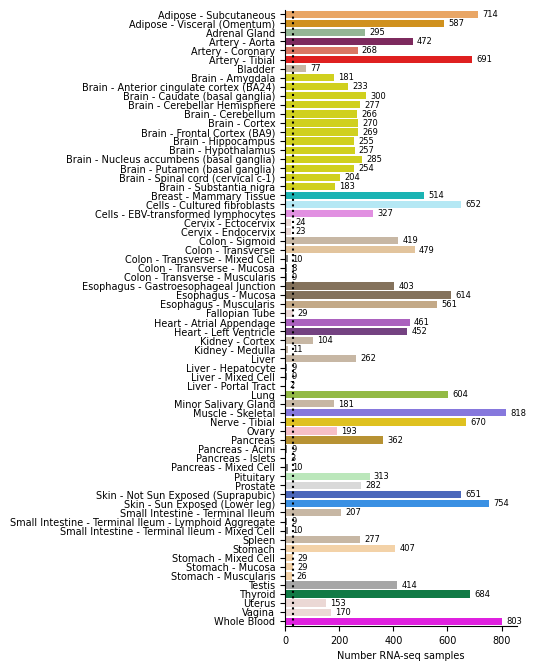

In [10]:
num_samples = pd.DataFrame(passed_samples.groupby('SMTSD').size()).rename(columns={0:'num_samples'})
num_samples = pd.merge(num_samples.reset_index(), tissue_df, right_on='tissue_name', left_on='SMTSD', how='left')
num_samples['tissue_color_hex'] = num_samples['tissue_color_hex'].fillna('#808080')


# plot the number of samples in each tissue
fig, ax = plt.subplots(figsize=(3,8))

sns.barplot(ax=ax,
              data=num_samples, 
              x='num_samples',
              hue='SMTSD',
              y='SMTSD',
              palette=sns.color_palette(num_samples['tissue_color_hex']),
              order=num_samples['SMTSD'],
              legend=False)

for container in ax.containers:
    ax.bar_label(container, fontsize=6, padding=3)

ax.set_xlabel('Number RNA-seq samples')
ax.set_ylabel('')
ax.axvline(tissue_cutoff, color='k', ls=':')

ax.spines[['top', 'right']].set_visible(False)
plt.show()


For each tissue, aggregate the samples gene counts for the actual genes and the matched null

In [11]:
# aggregate sample level counts to a df
def agg_rnaseqc(output_dir, tissue_sample_ids, file_end='gene_reads'):
    sample_tpms = []
    # get tpms for all samples 
    for sample_id in tqdm(tissue_sample_ids):
        expected_filename = f"{sample_id}.{file_end}.gct.gz"
        file_path = os.path.join(os.path.join(output_dir, 'rnaseq_qc'), expected_filename)
        if os.path.isfile(file_path):
            sample_tpms.append(pd.read_csv(file_path, sep='\t', skiprows=2).set_index(['Name', 'Description']))
        else:
            print(f"File not found: {file_path}")
    tpm_agg = pd.concat(sample_tpms, axis=1).reset_index()
    return tpm_agg


# get null and gene aggreagations (read in if exisitng otherwise create)
def get_aggregation_pair_tissue(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id, file_end='gene_reads'):
    print('Processing samples for {}'.format(tissue_id))
    sample_ids = tissue_sample_lists.loc[tissue_id]['SAMPID']
    tissue_id_clean = tissue_id.replace(' - ', '_').replace('-', '_').replace(' ', '_').replace('(', '').replace(')', '')

    gene_agg_path = os.path.join(os.path.join(rnaseqc_dir, 'rnaseqc_agg'), f"{tissue_id_clean}.v11.{file_end}.gct.gz")
    print(f'\t{gene_agg_path}')
    try:
        gene_agg = pd.read_csv(gene_agg_path, sep='\t')
    except FileNotFoundError:
        gene_agg = agg_rnaseqc(rnaseqc_dir, sample_ids, file_end=file_end)
        os.makedirs(os.path.join(rnaseqc_dir, 'rnaseqc_agg'), exist_ok=True)
        gene_agg.to_csv(gene_agg_path, sep='\t', index=False, compression='gzip')

    null_agg_path = os.path.join(os.path.join(null_dir, 'rnaseqc_agg') ,f"{tissue_id_clean}.v11_null.{file_end}.gct.gz")
    print(f'\t{null_agg_path}')
    try:
        null_agg = pd.read_csv(null_agg_path, sep='\t')
    except FileNotFoundError:
        null_agg = agg_rnaseqc(null_dir, sample_ids, file_end=file_end)
        os.makedirs(os.path.join(null_dir, 'rnaseqc_agg'), exist_ok=True)
        null_agg.to_csv(null_agg_path, sep='\t', index=False, compression='gzip')

    # null for mitochondial genes doesn't work, becuase there isn't enough null space on the mitochondiral genome
    print('\tRemoving {} mito genes that dont have matched null'.format(len(gene_agg[~gene_agg['Name'].isin(null_agg['Name'])])))
    gene_agg = gene_agg[gene_agg['Name'].isin(null_agg['Name'])]
    return gene_agg, null_agg

Processing samples for Testis
	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Testis.v11.gene_reads.gct.gz


	/home/klawren/oak/gtex/output/all_tissues_null/v11_intergenic/rnaseqc_agg/Testis.v11_null.gene_reads.gct.gz
	Removing 38 mito genes that dont have matched null


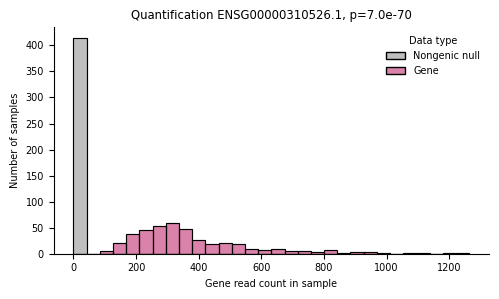

In [12]:
def plot_matched_null(sample_gene_id, gene_agg, null_agg):
    sample_columns = gene_agg.columns[2:]
    null_counts  = null_agg[null_agg['Name']==sample_gene_id][sample_columns].values[0]
    gene_counts  = gene_agg[gene_agg['Name']==sample_gene_id][sample_columns].values[0]
    stat, p_value = stats.wilcoxon(gene_counts, null_counts, alternative='greater')
    # plot the two distributions for a sample gene
    plot_df = pd.DataFrame({
        'count': np.concatenate([null_counts, gene_counts]),
        'distribution': ['Nongenic null'] * len(null_counts) + ['Gene'] * len(gene_counts)})

    fig, ax = plt.subplots(figsize=(5,3))
    if max(gene_counts) > 30:
        sns.histplot(plot_df,x='count', bins=30, hue='distribution', ax=ax, palette=['grey', '#b70657'])
    else:
        sns.histplot(plot_df,x='count', discrete=True, hue='distribution', ax=ax, palette=['grey', '#b70657'])
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('Gene read count in sample')
    ax.set_ylabel('Number of samples')
    # Customize the legend
    legend = ax.get_legend()
    legend.get_frame().set_visible(False)
    legend.set_title("Data type")
    ax.set_title('Quantification {}, p={:.1e}'.format(sample_gene_id, p_value))
    fig.tight_layout()

gene_agg, null_agg = get_aggregation_pair_tissue(rnaseqc_dir, null_dir, tissue_sample_lists, 'Testis')
plot_matched_null(gene_agg['Name'].iloc[1], gene_agg, null_agg)

In [13]:
# get p values for the tissue
def get_tissue_pvalues(gene_agg, null_agg):
    print('\tCalculating p values...')

    sample_columns = gene_agg.columns[2:]
    null_counts_array = null_agg.set_index('Name').loc[gene_agg['Name']][sample_columns].values
    gene_counts_array = gene_agg.set_index('Name').loc[gene_agg['Name']][sample_columns].values

    p_values = np.empty(len(gene_agg['Name']))
    median_counts = np.empty(len(gene_agg['Name']))
    mean_counts = np.empty(len(gene_agg['Name']))
    median_null_counts = np.empty(len(gene_agg['Name']))
    mean_null_counts = np.empty(len(gene_agg['Name']))

    for idx in tqdm(range(len(gene_agg['Name'])), total=len(gene_agg['Name'])):
        null_counts = null_counts_array[idx]
        gene_counts = gene_counts_array[idx]
        if np.all(gene_counts == 0) or np.all(gene_counts == null_counts):
            # if all are the zero
            p_value = 1
        else:
            stat, p_value = stats.wilcoxon(gene_counts, null_counts, alternative='greater')
            
        p_values[idx] = p_value
        median_counts[idx] = np.median(gene_counts)
        mean_counts[idx] = np.mean(gene_counts)
        median_null_counts[idx] = np.median(null_counts)
        mean_null_counts[idx] = np.mean(null_counts)
    return p_values, median_counts, mean_counts, median_null_counts, mean_null_counts

def get_null_quantifications(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id):

    tissue_id_clean = tissue_id.replace(' - ', '_').replace('-', '_').replace(' ', '_').replace('(', '').replace(')', '')
    quantifications_path = os.path.join(os.path.join(rnaseqc_dir, 'rnaseqc_agg'), f"{tissue_id_clean}.v11.null_quantifications.txt")
    print(f'\t{quantifications_path}')

    try:
        quantifications = pd.read_csv(quantifications_path, sep='\t')
        num_considered = (quantifications[f'{tissue_id}.mean_counts'] > 0).sum()
        quantifications[f'{tissue_id}.quantified_corrected'] = quantifications[f'{tissue_id}.null_p'] < (.05/num_considered)
        
    except FileNotFoundError:
        os.makedirs(os.path.join(rnaseqc_dir, 'rnaseqc_agg'), exist_ok=True)

        gene_agg, null_agg = get_aggregation_pair_tissue(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id)
        p_values, median_counts, mean_counts, median_null_counts, mean_null_counts = get_tissue_pvalues(gene_agg, null_agg)

        quantifications = pd.DataFrame({'Name':gene_agg['Name']})
        quantifications[f'{tissue_id}.null_p'] = p_values
        quantifications[f'{tissue_id}.median_counts'] = median_counts
        quantifications[f'{tissue_id}.mean_counts'] = mean_counts
        quantifications[f'{tissue_id}.median_null_counts'] = median_null_counts
        quantifications[f'{tissue_id}.mean_null_counts'] = mean_null_counts
        quantifications[f'{tissue_id}.quantified'] = quantifications[f'{tissue_id}.null_p'] < (.05/len(quantifications))
        num_considered = (quantifications[f'{tissue_id}.mean_counts'] > 0).sum()
        quantifications[f'{tissue_id}.quantified_corrected'] = quantifications[f'{tissue_id}.null_p'] < (.05/num_considered)
        quantifications.to_csv(quantifications_path, sep='\t', index=False)

    return quantifications

look at one of the lower sample size ones - fallopian tube. I think that the sample size is too low here. looks like lots of false negatives - this would indicate to me that we need to limit to tissues with > 30 samples

In [14]:
tissue_id = 'Whole Blood'
test_quantifications = get_null_quantifications(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id)

	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Whole_Blood.v11.null_quantifications.txt


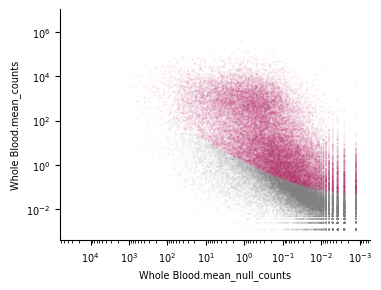

In [15]:
fig, ax = plt.subplots(figsize=(4,3))

sns.scatterplot(test_quantifications, ax=ax, x=f'{tissue_id}.mean_null_counts', y=f'{tissue_id}.mean_counts', hue=f'{tissue_id}.quantified_corrected', alpha=.05, s=2, legend=False, palette=['grey', '#b70657'])
ax.set_xscale('log')
ax.invert_xaxis()
ax.set_yscale('log')
ax.spines[['top', 'right']].set_visible(False)
plt.show()

Scale up and look across tissues

In [16]:
# only consider those with more that 20 samples

print(passed_samples.groupby('SMTSD').size()[passed_samples.groupby('SMTSD').size() < tissue_cutoff]) 
large_sample_size_tissues = passed_samples.groupby('SMTSD').size()[passed_samples.groupby('SMTSD').size() > tissue_cutoff].index
print('continuing with {} tissues'.format(len(large_sample_size_tissues)))

tissue_sample_lists = tissue_sample_lists[tissue_sample_lists.index.isin(large_sample_size_tissues)]
passed_samples = passed_samples[passed_samples['SMTSD'].isin(large_sample_size_tissues)]
tissue_color_df = tissue_df[tissue_df['tissue_name'].isin(large_sample_size_tissues)]
tissue_color_palette = sns.color_palette(tissue_color_df['tissue_color_hex'])

SMTSD
Cervix - Ectocervix                                      24
Cervix - Endocervix                                      23
Colon - Transverse - Mixed Cell                          10
Colon - Transverse - Mucosa                               8
Colon - Transverse - Muscularis                           9
Fallopian Tube                                           29
Kidney - Medulla                                         11
Liver - Hepatocyte                                        9
Liver - Mixed Cell                                        9
Liver - Portal Tract                                      2
Pancreas - Acini                                          9
Pancreas - Islets                                         3
Pancreas - Mixed Cell                                    10
Small Intestine - Terminal Ileum - Lymphoid Aggregate     9
Small Intestine - Terminal Ileum - Mixed Cell            10
Stomach - Mixed Cell                                     29
Stomach - Mucosa                  

In [17]:
quantifications = get_null_quantifications(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_sample_lists.index.values[0])
for tissue_id in tissue_sample_lists.index.values[1:]:
    quantifications = pd.merge(quantifications, get_null_quantifications(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id), on='Name')

# add in gene type information
quantifications = pd.merge(quantifications, gencode_ids[~gencode_ids['gene_id_v47'].isna()], left_on='Name', right_on='gene_id_v47', how='right')

	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Adipose_Subcutaneous.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Adipose_Visceral_Omentum.v11.null_quantifications.txt


	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Adrenal_Gland.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Artery_Aorta.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Artery_Coronary.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Artery_Tibial.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Bladder.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Brain_Amygdala.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Brain_Anterior_cingulate_cortex_BA24.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Brain_Caudate_basal_ganglia.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues_old/rnaseqc_agg/Brain_Cerebellar_Hemisphere.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_

In [18]:
gencode_ids[~gencode_ids['gene_id_v47'].isna()]['gene_type_grouped_highlight'].value_counts()

gene_type_grouped_highlight
protein_coding     20503
new_lncRNA         18312
existing_lncRNA    17622
pseudogene         14703
sRNA                7565
artifact              19
Name: count, dtype: int64

In [19]:
quantifications['gene_type_grouped_highlight'].value_counts()

gene_type_grouped_highlight
protein_coding     20503
new_lncRNA         18312
existing_lncRNA    17622
pseudogene         14703
sRNA                7565
artifact              19
Name: count, dtype: int64

In [20]:
# fill in 0s for genes not every quatified (lost due to overlap)
quantification_columns = [f'{tissue_id}.quantified_corrected' for tissue_id in tissue_sample_lists.index.values]
quantifications[quantification_columns] = quantifications[quantification_columns].fillna(0)

null counts sanity check 

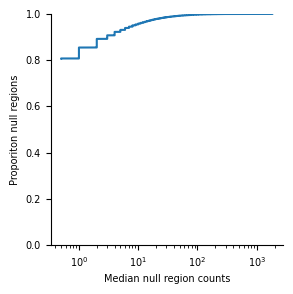

In [21]:
# null counts
null_counts_columns = [f'{tissue_id}.median_null_counts' for tissue_id in tissue_sample_lists.index.values]

null_counts = quantifications[null_counts_columns[:-5]].median(axis=1)
fig, ax = plt.subplots(figsize=(3,3))


sns.ecdfplot(ax=ax,
              data=null_counts, 
              log_scale=True)

ax.set_xlabel('Median null region counts')
ax.set_ylabel('Proporiton null regions')
ax.spines[['top', 'right']].set_visible(False)


proportion that are expressed

In [22]:
# proportion of group expressed in each tissue category
quantification_columns = [f'{tissue_id}.quantified_corrected' for tissue_id in tissue_sample_lists.index.values]

proportion_expressed = quantifications.groupby('gene_type_grouped_highlight').agg({tissue: 'mean' for tissue in quantification_columns})
proportion_expressed = proportion_expressed.reset_index().melt(id_vars='gene_type_grouped_highlight', value_vars=quantification_columns, value_name='proportion_expressed')
proportion_expressed['tissue'] = proportion_expressed['variable'].str.split('.quantified').str[0]

In [23]:
proportion_expressed

,gene_type_grouped_highlight,variable,proportion_expressed,tissue
0,artifact,Adipose - Subcutaneous.quantified_corrected,0.526316,Adipose - Subcutaneous
1,existing_lncRNA,Adipose - Subcutaneous.quantified_corrected,0.621042,Adipose - Subcutaneous
2,new_lncRNA,Adipose - Subcutaneous.quantified_corrected,0.447412,Adipose - Subcutaneous
3,protein_coding,Adipose - Subcutaneous.quantified_corrected,0.881968,Adipose - Subcutaneous
4,pseudogene,Adipose - Subcutaneous.quantified_corrected,0.352717,Adipose - Subcutaneous
...,...,...,...,...
295,existing_lncRNA,Whole Blood.quantified_corrected,0.505902,Whole Blood
296,new_lncRNA,Whole Blood.quantified_corrected,0.343818,Whole Blood
297,protein_coding,Whole Blood.quantified_corrected,0.868605,Whole Blood
298,pseudogene,Whole Blood.quantified_corrected,0.30368,Whole Blood


/local/scratch/klawren/slrmtmp.48870051/ipykernel_35777/3141292182.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/local/scratch/klawren/slrmtmp.48870051/ipykernel_35777/3141292182.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_swarm.set_yticklabels(['new lncRNA', 'existing lncRNA', 'protein coding'])
/local/scratch/klawren/slrmtmp.48870051/ipykernel_35777/3141292182.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_swarm.set_yticklabels(xtick_labels)
/local/scratch/klawren/slrmtmp.48870051/ipykernel_35777/3141292182.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable 

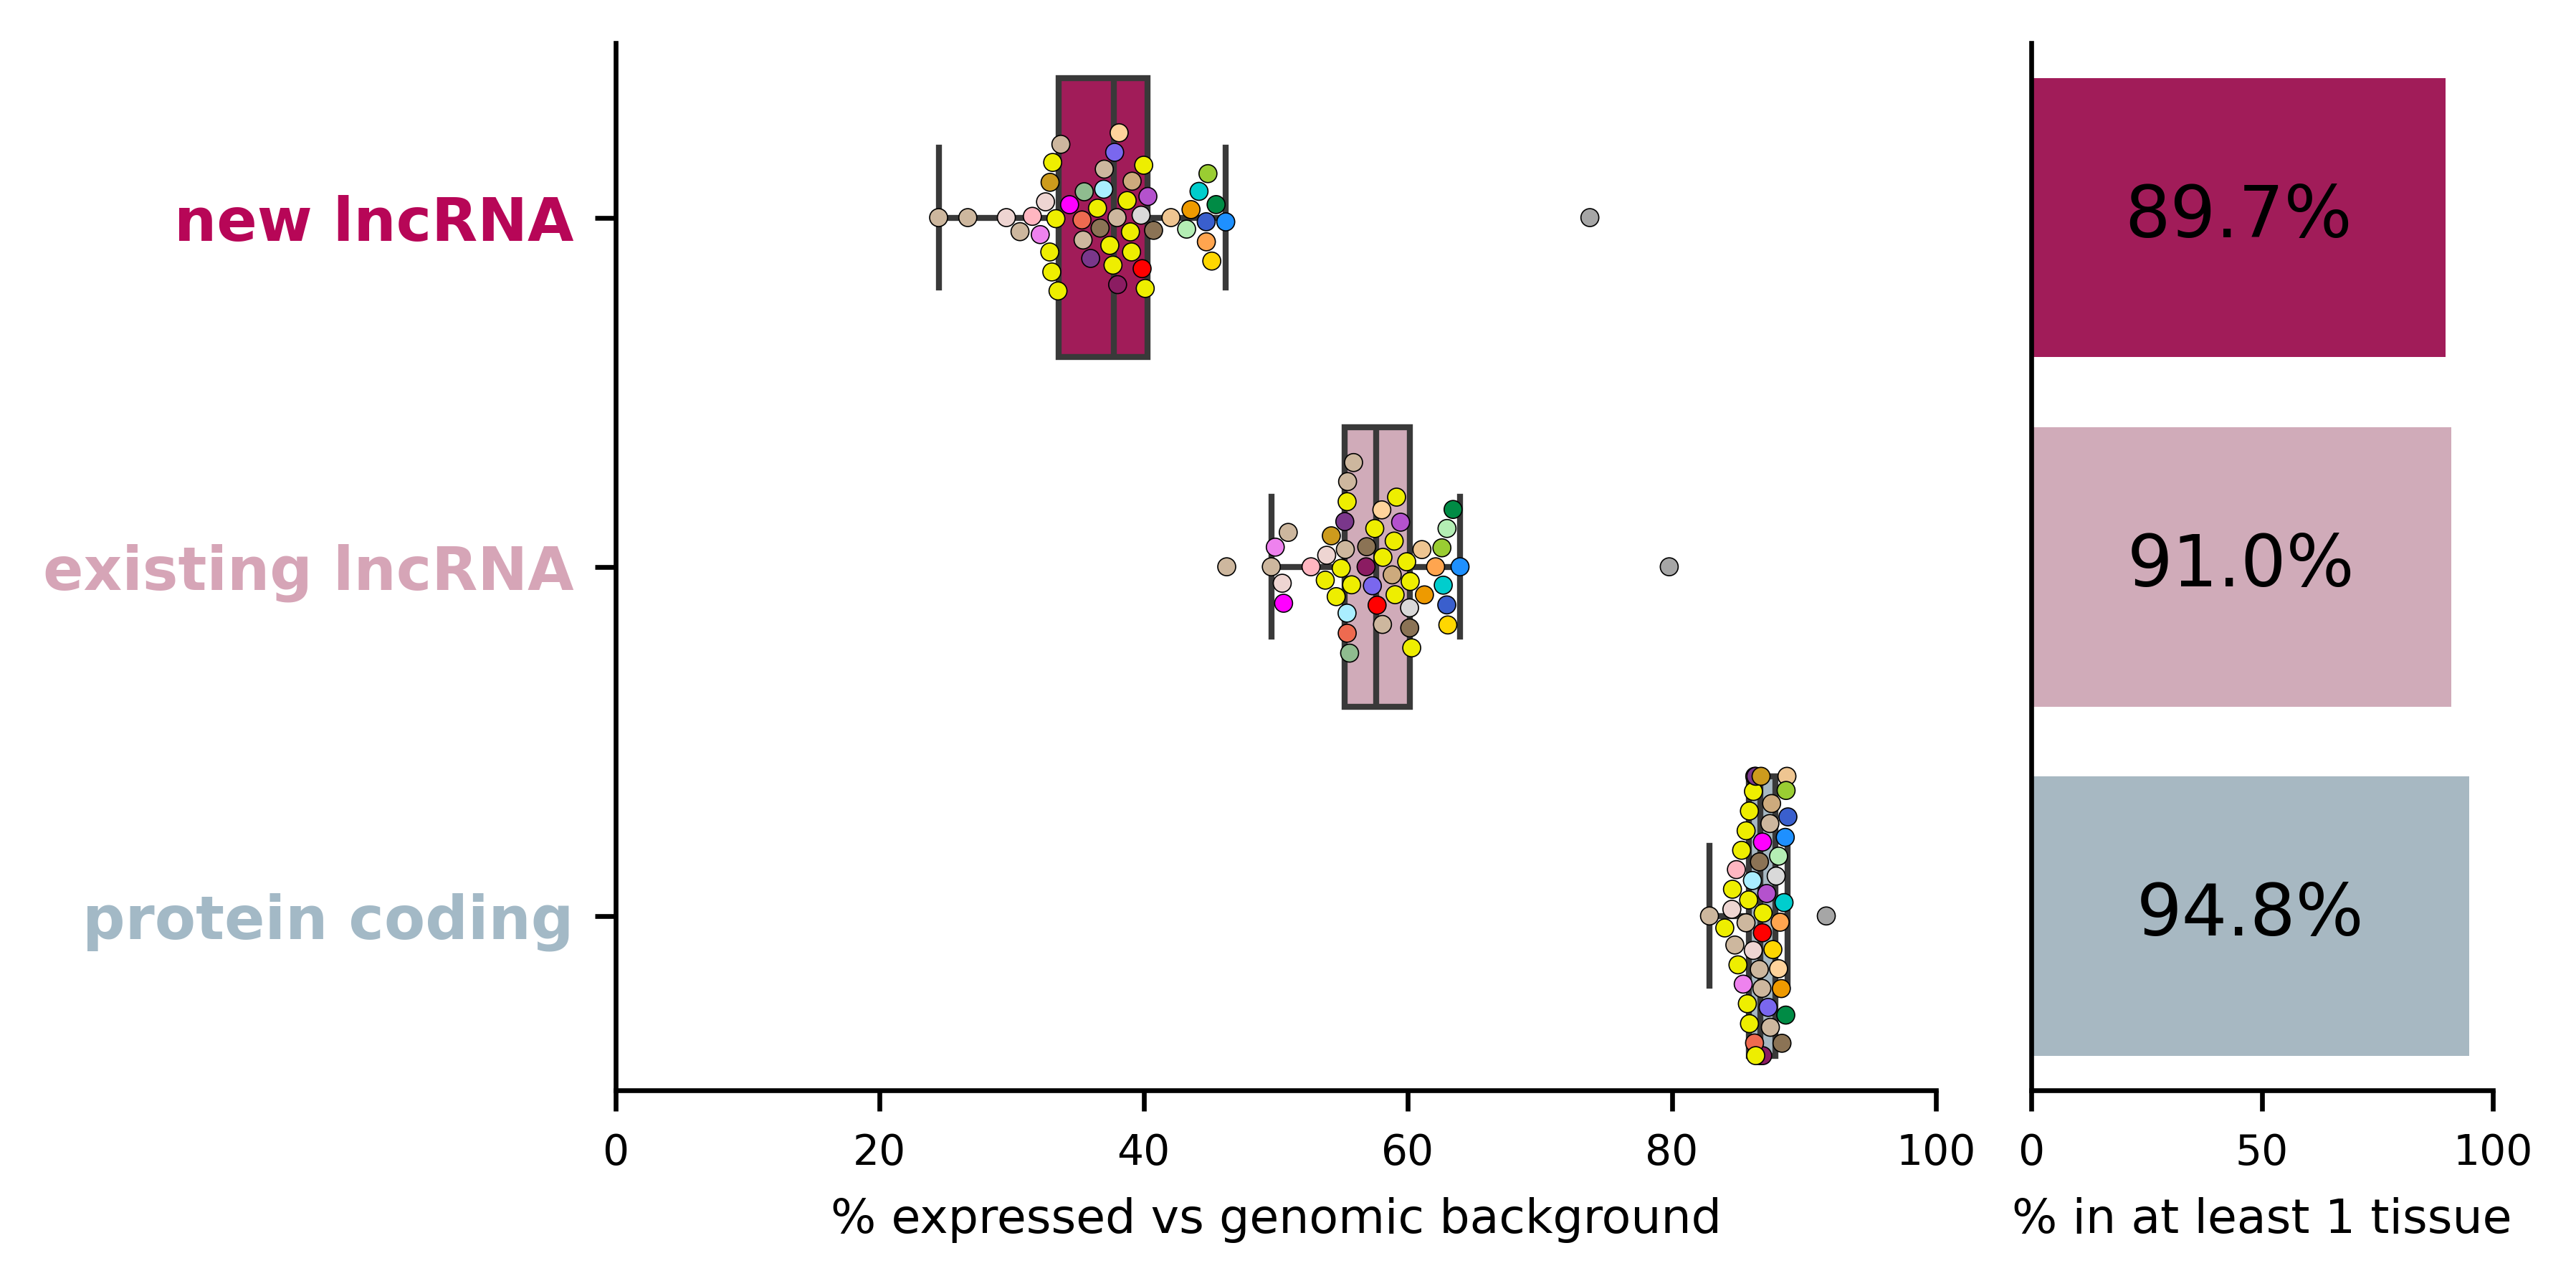

In [65]:
# Plot percent quantified in any tissue for each gene type on the right, and the main swarm/boxplot on the left

# Calculate percent quantified in any tissue for each group
num_tissues = 50
quantifications['num_quantified'] = quantifications[quantification_columns].sum(axis=1)
quantifications['num_not_quantified'] = num_tissues - quantifications['num_quantified']

# For each group, percent with num_quantified > 0
gene_types = ['new_lncRNA', 'existing_lncRNA', 'protein_coding']
any_expr_props = (
    quantifications.groupby('gene_type_grouped_highlight')['num_quantified']
    .apply(lambda x: (x > 0).mean())
    .reindex(gene_types)
)
any_expr_props = any_expr_props * 100  # convert to percent

# Set up the figure with two subplots: left for swarm/box, right for bar
fig, (ax_swarm, ax_bar) = plt.subplots(
    ncols=2, 
    figsize=(6, 3), 
    dpi=600, 
    gridspec_kw={'width_ratios': [2, 0.7]}
)

# Main plot: swarm and boxplot (left)
proportion_expressed['percent_expressed'] = proportion_expressed['proportion_expressed'] * 100
plot_data = proportion_expressed[proportion_expressed['gene_type_grouped_highlight'].isin(gene_types)]

# Swarmplot: tissue points
sns.swarmplot(
    data=plot_data,
    ax=ax_swarm,
    hue='tissue',
    y='gene_type_grouped_highlight',
    x='percent_expressed',
    palette=tissue_color_map,
    linewidth=0.2,
    edgecolor='black',
    legend=False,
    zorder=2,
    s=3,
    order=gene_types
)

# Boxplot: colored by gene type
sns.boxplot(
    data=plot_data,
    x='percent_expressed',
    y='gene_type_grouped_highlight',
    legend=None,
    fill=True,
    fliersize=0,
    ax=ax_swarm,
    palette=[gene_type_pal_greyed[gt] for gt in gene_types],
    zorder=1,
    order=gene_types
)

ax_swarm.spines[['top', 'right']].set_visible(False)
ax_swarm.set_xlabel('% expressed vs genomic background', fontsize=8)
ax_swarm.set_ylabel('')
ax_swarm.set_xlim([0, 100])
ax_swarm.set_yticklabels(['new lncRNA', 'existing lncRNA', 'protein coding'])

# Color the x-tick labels to match gene type colors and make them larger
xtick_labels = ax_swarm.get_yticklabels()
for label, gt in zip(xtick_labels, gene_types):
    label.set_color(gene_type_pal_greyed[gt])
    label.set_fontsize(10)
    label.set_fontweight('bold')
ax_swarm.set_yticklabels(xtick_labels)

# Barplot: percent quantified in any tissue (right)
bar_colors = [gene_type_pal_greyed[gt] for gt in gene_types]
sns.barplot(
    x=any_expr_props.values,
    y=gene_types,
    orient='h',
    palette=bar_colors,
    ax=ax_bar
)
ax_bar.set_xlim(0, 100)
ax_bar.set_xlabel('% in at least 1 tissue', fontsize=8)
ax_bar.set_ylabel('')
ax_bar.spines[['top', 'right']].set_visible(False)
ax_bar.set_yticks([])  # Remove y ticks

# Add bar labels directly on the bars
for i, (value, gt) in enumerate(zip(any_expr_props.values, gene_types)):
    ax_bar.text(
        value / 2,  # Center label on the bar
        i,
        f"{value:.1f}%",
        va='center',
        ha='center',
        color='black', 
        fontsize=12
    )

plt.tight_layout(w_pad=1)
plt.show()

In [ ]:
proportion_expressed.groupby('gene_type_grouped_highlight')['percent_expressed'].median()


gene_type_grouped_highlight
artifact           47.368421
existing_lncRNA     57.58427
new_lncRNA         37.732088
protein_coding     86.711701
pseudogene          29.23553
sRNA                13.01388
Name: percent_expressed, dtype: object

how many quantified in any tissue?

/local/scratch/klawren/slrmtmp.48865987/ipykernel_1192/2943986184.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quantifications['num_quantified'] = quantifications[quantification_columns].sum(axis=1)
/local/scratch/klawren/slrmtmp.48865987/ipykernel_1192/2943986184.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quantifications['num_not_quantified'] = num_tissues - quantifications['num_quantified']


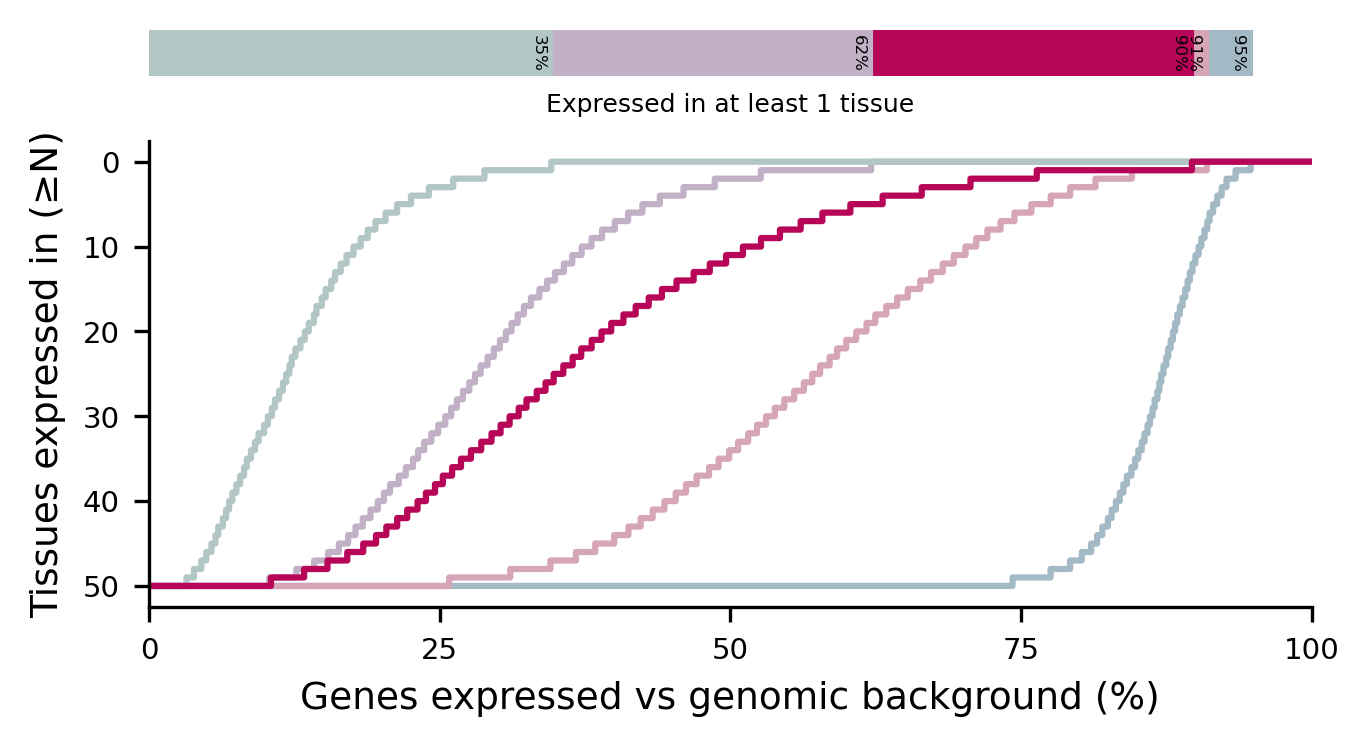

In [ ]:
num_tissues = 50
quantifications['num_quantified'] = quantifications[quantification_columns].sum(axis=1)
quantifications['num_not_quantified'] = num_tissues - quantifications['num_quantified'] 


# Calculate proportion expressed in 0 tissues for each group
zero_expr_props = (
    quantifications.groupby('gene_type_grouped_highlight')['num_not_quantified']
    .apply(lambda x: (x == num_tissues).mean())
    .reindex(['new_lncRNA', 'protein_coding', 'sRNA','pseudogene', 'existing_lncRNA'])
)

# Set up figure with two axes: bar on top, ECDF below
fig = plt.figure(figsize=(5, 2.5), dpi=300)
gs = fig.add_gridspec(2, 1, height_ratios=[.2, 2], hspace=0.25)
ax_bar = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

# Horizontal stacked bar plot for proportion expressed in 0 tissues, sorted by value
sorted_zero_expr = zero_expr_props.sort_values(ascending=True)
bar_colors = [gene_type_pal_greyed[gt] for gt in sorted_zero_expr.index]

left = 0
for i, (idx, val) in enumerate(sorted_zero_expr.items()):
    ax_bar.barh(
        y=0,
        width=1-val,
        left=0,
        edgecolor=bar_colors[i],
        height=1.0,
        color=bar_colors[i],
        alpha=1.0,
        label=idx
    )
    # Add bar label at the center of each segment
    ax_bar.text(
        1-val-.005, 0,
        f"{1-val:.0%}",
        va='center',
        ha='right',
        color= 'k',
        fontsize=4,
        rotation=-90
    )

ax_bar.set_yticks([])
ax_bar.set_ylabel('')
ax_bar.set_xlim(0,1)
ax_bar.set_xlabel('Expressed in at least 1 tissue', fontsize=6)
ax_bar.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax_bar.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_bar.tick_params(axis='y', length=2)

# ECDF plot for number of tissues expressed in, by gene type
sns.ecdfplot(
    ax=ax,
    data=quantifications,
    y='num_not_quantified',
    hue='gene_type_grouped_highlight',
    hue_order=['new_lncRNA', 'existing_lncRNA', 'protein_coding', 'sRNA','pseudogene'],
    palette=gene_type_pal_greyed, 
    linewidth=1.5
)

#ax.axhspan(49, 50, color='#E98300', alpha=0.3, lw=0, zorder=10, )  

ax.set_xlabel('Genes expressed vs genomic background (%)', fontsize=9)
ax.set_xticks([0, .25, .5, .75, 1])
ax.set_xticklabels([0, 25, 50, 75, 100])
ax.set_ylabel('Tissues expressed in (≥N)', fontsize=9)
ax.set_yticks([0, 10, 20, 30, 40, 50])
ax.set_yticklabels([0, 10, 20, 30, 40, 50][::-1])
ax.spines[['top', 'right']].set_visible(False)
plt.setp(ax.get_legend(), visible=False)
plt.show()

tissue sharing vs sepcificity

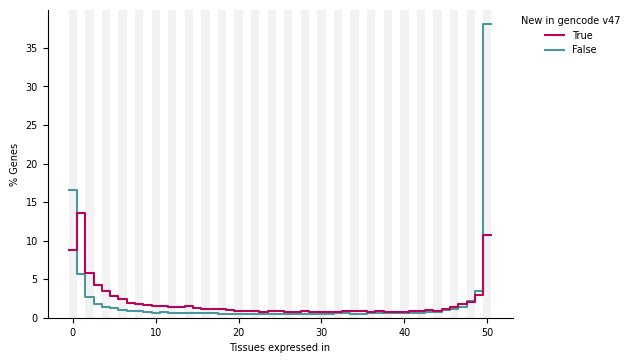

85.3% are quantified in at least one tissue
	91.2% new in v47 are quantified in at least one tissue
	79.7% are quantified in at least one tissue excluding testis


In [ ]:
quantifications['new_to_v47'] = quantifications['Name'].isin(gencode_ids[~gencode_ids['in_v39_full']]['gene_id_v47'])
quantifications['num_quantified'] = quantifications[quantification_columns].sum(axis=1)

fig, ax = plt.subplots(figsize=(6,4))

sns.histplot(ax=ax,
              data=quantifications, 
              x='num_quantified', 
              hue='new_to_v47',
              palette=['#b70657', '#4a989c'],
              hue_order=[True, False], 
              discrete=True,
              element='step', 
              fill=False, 
              stat='percent', 
              common_norm=False)

ax.set_ylabel('% Genes')
ax.set_xlabel('Tissues expressed in')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.01), frameon=False, title='New in gencode v47')
ax.spines[['top', 'right']].set_visible(False)
for i in range(0, len(large_sample_size_tissues)+1, 2):  
    ax.axvspan(i-.5, i+.5, color='grey', alpha=0.1, lw=0)  

plt.show()

print('{:.1f}% are quantified in at least one tissue'.format((quantifications['num_quantified'] != 0).mean()*100))
print('\t{:.1f}% new in v47 are quantified in at least one tissue'.format((quantifications[quantifications['new_to_v47']]['num_quantified'] != 0).mean()*100))
quantifications['num_quantified_non_testis'] = quantifications[[*quantification_columns[:-5] , *quantification_columns[-4:]]].sum(axis=1)
print('\t{:.1f}% are quantified in at least one tissue excluding testis'.format((quantifications['num_quantified_non_testis'] != 0).mean()*100))


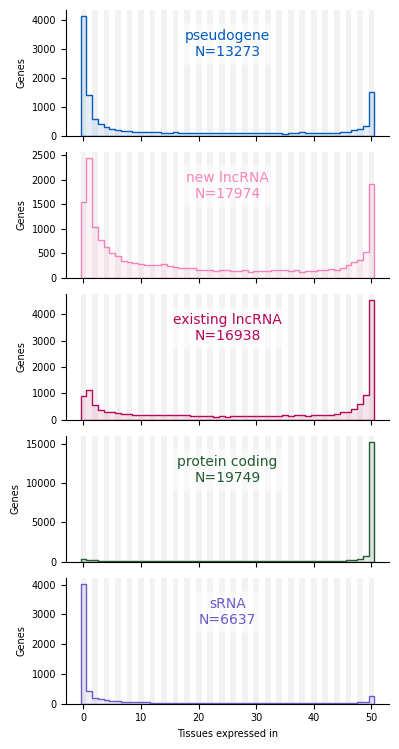

In [ ]:
gene_types = quantifications['gene_type_grouped_highlight'].unique()
gene_types = gene_types[gene_types!='artifact']

fig, axes = plt.subplots(nrows=len(gene_types), ncols=1, figsize=(4, 1.5 * len(gene_types)), sharex=True)

# Create a histogram for each gene type in separate subplots
for ax, gene_type in zip(axes, gene_types):
    sub_group = quantifications[quantifications['gene_type_grouped_highlight'] == gene_type]
    sns.histplot(ax=ax,
                 data=sub_group, 
                 x='num_quantified', 
                 color=gene_type_pal_highlight[gene_type],
                 discrete=True,
                 element='step', 
                 stat='count', 
                 common_norm=False, 
                 alpha=.1)
    ax.text(0.5, 0.85, '{}\nN={}'.format(gene_type.replace('_', ' '), len(sub_group)), transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), color=gene_type_pal_highlight[gene_type])



    ax.set_ylabel('Genes')
    ax.spines[['top', 'right']].set_visible(False)
    for i in range(0, len(large_sample_size_tissues)+1, 2):  
        ax.axvspan(i-.5, i+.5, color='grey', alpha=0.1, lw=0)  

axes[-1].set_xlabel('Tissues expressed in')

plt.tight_layout()
plt.show()


look at patterns of tissue sharing

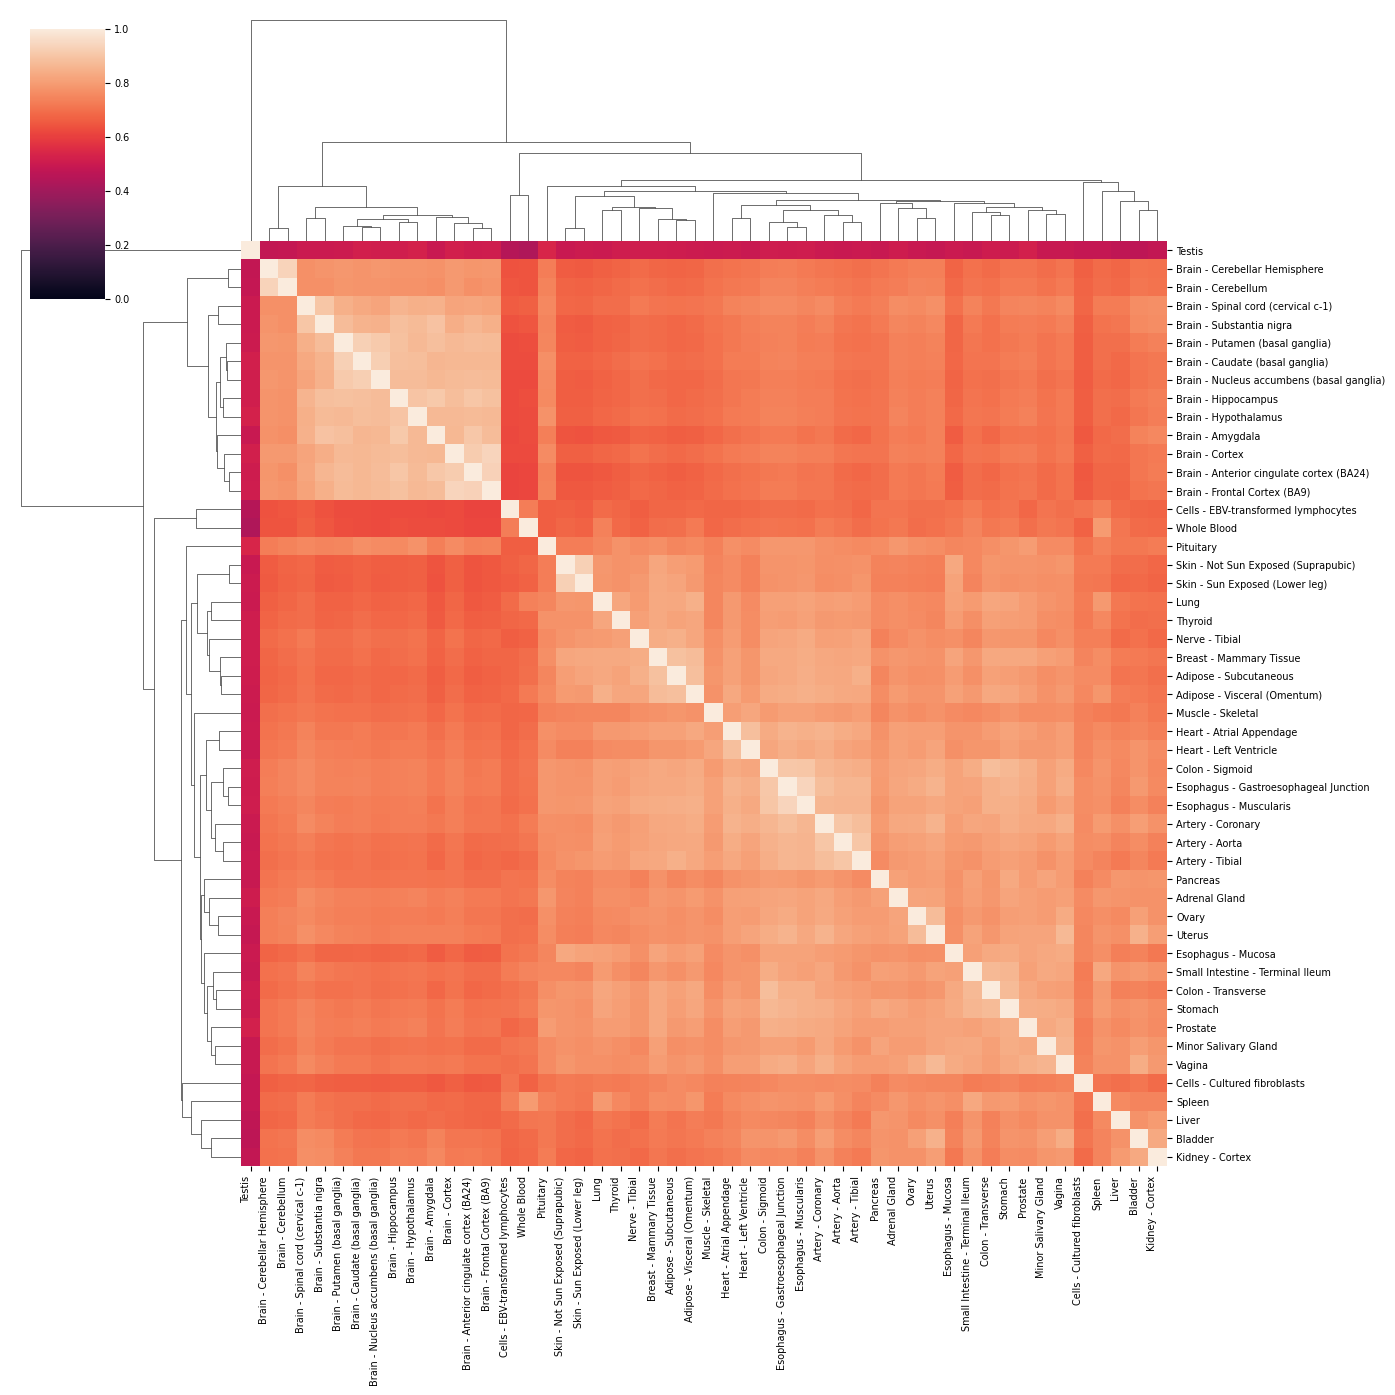

In [ ]:
# heatmap for quantification, using all genes
quantification_df = quantifications.set_index('Name')[quantification_columns]
g = sns.clustermap(quantification_df.corr(method='spearman').fillna(0), 
               figsize=(15, 15), 
               vmin=0, 
               vmax=1)

new_labels_x = [label.get_text().replace('.quantified_corrected', '') for label in g.ax_heatmap.get_xticklabels()]
g.ax_heatmap.set_xticklabels(new_labels_x, rotation=90, ha='right')
new_labels_y = [label.get_text().replace('.quantified_corrected', '') for label in g.ax_heatmap.get_yticklabels()]
g.ax_heatmap.set_yticklabels(new_labels_y, rotation=0)

plt.show()

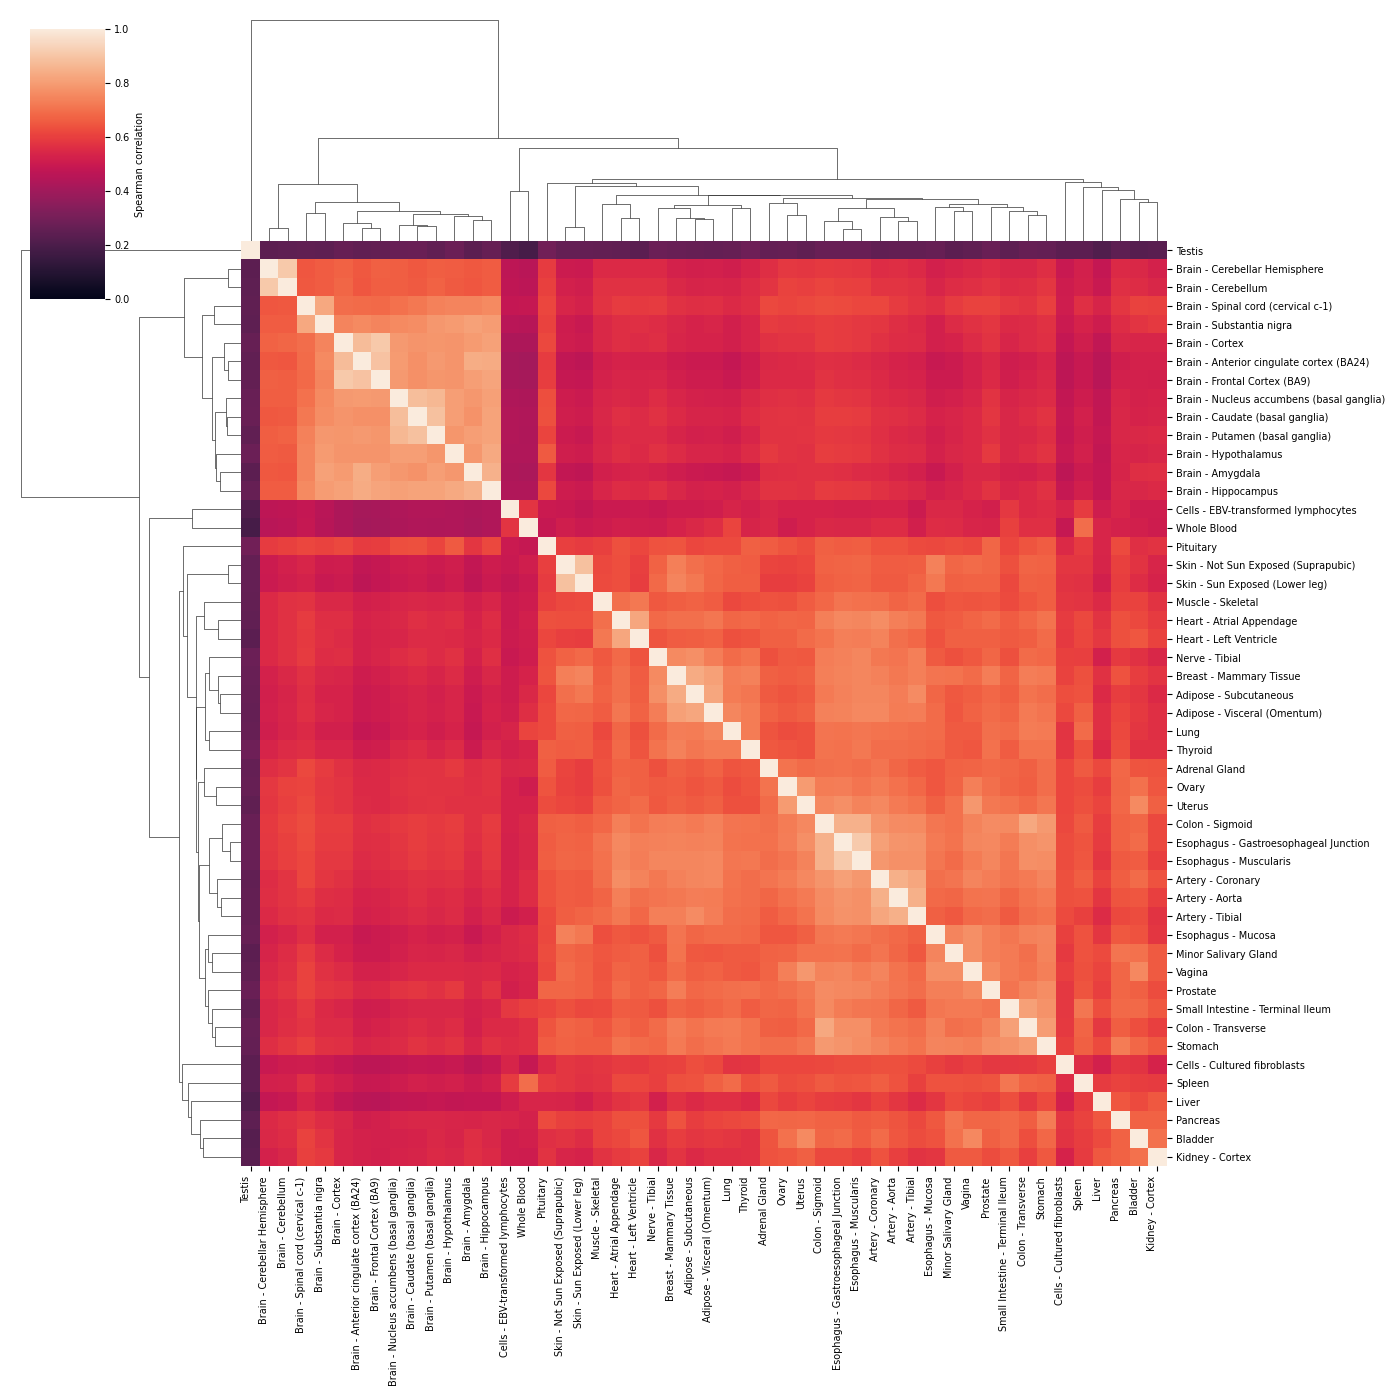

In [ ]:
# heatmap for quantification, using just new lncRNAs
quantification_df = quantifications[quantifications['gene_type_grouped_highlight'] =='new_lncRNA'].set_index('Name')[quantification_columns]
g = sns.clustermap(quantification_df.corr(method='spearman').fillna(0), 
               figsize=(15, 15), 
               vmin=0, 
               vmax=1, 
               cbar_kws={'label': 'Spearman correlation'}, 
               cmap='rocket')

new_labels_x = [label.get_text().replace('.quantified_corrected', '') for label in g.ax_heatmap.get_xticklabels()]
g.ax_heatmap.set_xticklabels(new_labels_x, rotation=90, ha='right')
new_labels_y = [label.get_text().replace('.quantified_corrected', '') for label in g.ax_heatmap.get_yticklabels()]
g.ax_heatmap.set_yticklabels(new_labels_y, rotation=0)

plt.show()

now look at larger "tissue groups"

In [46]:
tissue_groups = sample_meta[sample_meta['SMTSD'].isin(large_sample_size_tissues)].groupby('SMTS').agg({'SMTSD':'unique'})
for tissue_group, tissue_names in tissue_groups.iterrows():
    quantifications[f'{tissue_group}.group.quantified'] = quantifications[[f'{t}.quantified_corrected' for t in tissue_names['SMTSD']]].sum(axis=1) > 0

tissue_group_columns = [f'{t}.group.quantified' for t in tissue_groups.index]

/local/scratch/klawren/slrmtmp.48870051/ipykernel_35777/398112257.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quantifications[f'{tissue_group}.group.quantified'] = quantifications[[f'{t}.quantified_corrected' for t in tissue_names['SMTSD']]].sum(axis=1) > 0
/local/scratch/klawren/slrmtmp.48870051/ipykernel_35777/398112257.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quantifications[f'{tissue_group}.group.quantified'] = quantifications[[f'{t}.quantified_corrected' for t in tissue_names['SMTSD']]].sum(axis=1) > 0
/l

/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


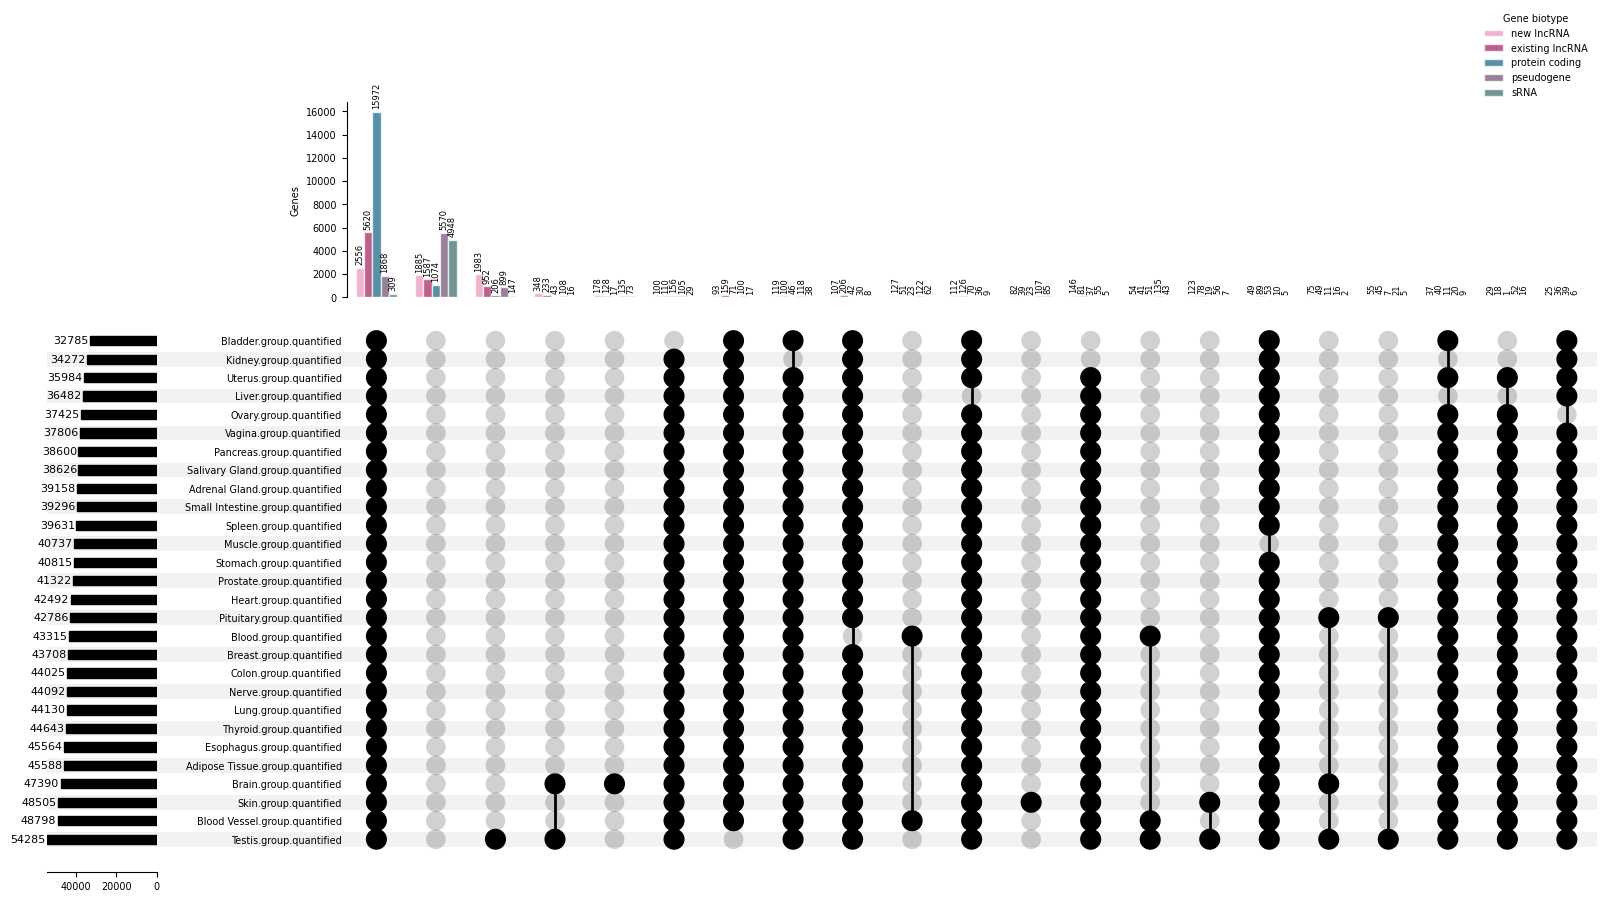

In [47]:
tissue_group_upset = up.from_indicators(quantifications[tissue_group_columns], data=quantifications['gene_type_grouped_highlight'])
min_size = 100
tissue_group_upset = pd.DataFrame(tissue_group_upset)
upset_categories =tissue_group_upset.index.value_counts()[tissue_group_upset.index.value_counts() > min_size].index
category_to_idx = {category: idx for idx, category in enumerate(upset_categories)}
tissue_group_upset['idx_loc'] = tissue_group_upset.index.map(category_to_idx)

fig = plt.figure(figsize=(20, 10))
upset = up.UpSet(tissue_group_upset, show_counts=False, subset_size='count', intersection_plot_elements=10, totals_plot_elements=2, element_size=None, sort_by='cardinality', min_subset_size=min_size)
plot_result = upset.plot(fig=fig, )

print(plot_result.keys())

totals_ax = plot_result['totals']
totals_ax.grid(False)
# add numbers to plot
for container in totals_ax.containers:
    totals_ax.bar_label(container, padding=1, fontsize=8,)

bar_ax = plot_result['intersections']
bar_ax.clear()
sns.countplot(tissue_group_upset.reset_index(), x='idx_loc', hue='gene_type_grouped_highlight',ax=bar_ax, palette=gene_type_pal_highlight, hue_order=gene_type_order_highlight, alpha=.7, edgecolor='white', width=.7)
bar_ax.set_ylabel('Genes')
#bar_ax.set_yscale('log')

# add numbers to plot
for container in bar_ax.containers:
    bar_ax.bar_label(container, padding=2, fontsize=6, rotation=90)

sns.move_legend(bar_ax, "upper right", bbox_to_anchor=(1, 1.5), frameon=False, title='Gene biotype')
legend = bar_ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)

In [48]:
# Only expressed in 1 tissue
unique_genes = quantifications[quantifications[tissue_group_columns].sum(axis=1) == 1]

# Only expressed in one tissue (excluding testis)
non_testis_tissue_groups = [t for t in tissue_group_columns if t != 'Testis.group.quantified']
non_testis_unique = quantifications[quantifications[non_testis_tissue_groups].sum(axis=1) == 1].copy()
non_testis_unique['Testis.group.quantified'] = 0

unique_genes = pd.DataFrame(
    unique_genes[unique_genes['gene_type_grouped_highlight'] == 'new_lncRNA'][tissue_group_columns].sum(axis=0)
).rename(columns={0: 'unique'})
non_testis_unique = pd.DataFrame(
    non_testis_unique[non_testis_unique['gene_type_grouped_highlight'] == 'new_lncRNA'][tissue_group_columns].sum(axis=0)
).rename(columns={0: 'non_testis_unique'})

unique_gene_counts = pd.merge(non_testis_unique.reset_index(), unique_genes.reset_index(), on='index')
unique_gene_counts['tissue_group'] = unique_gene_counts['index'].str.split('.group').str[0]
unique_gene_counts = unique_gene_counts.melt(
    id_vars='tissue_group', value_name='genes', value_vars=['non_testis_unique', 'unique']
)

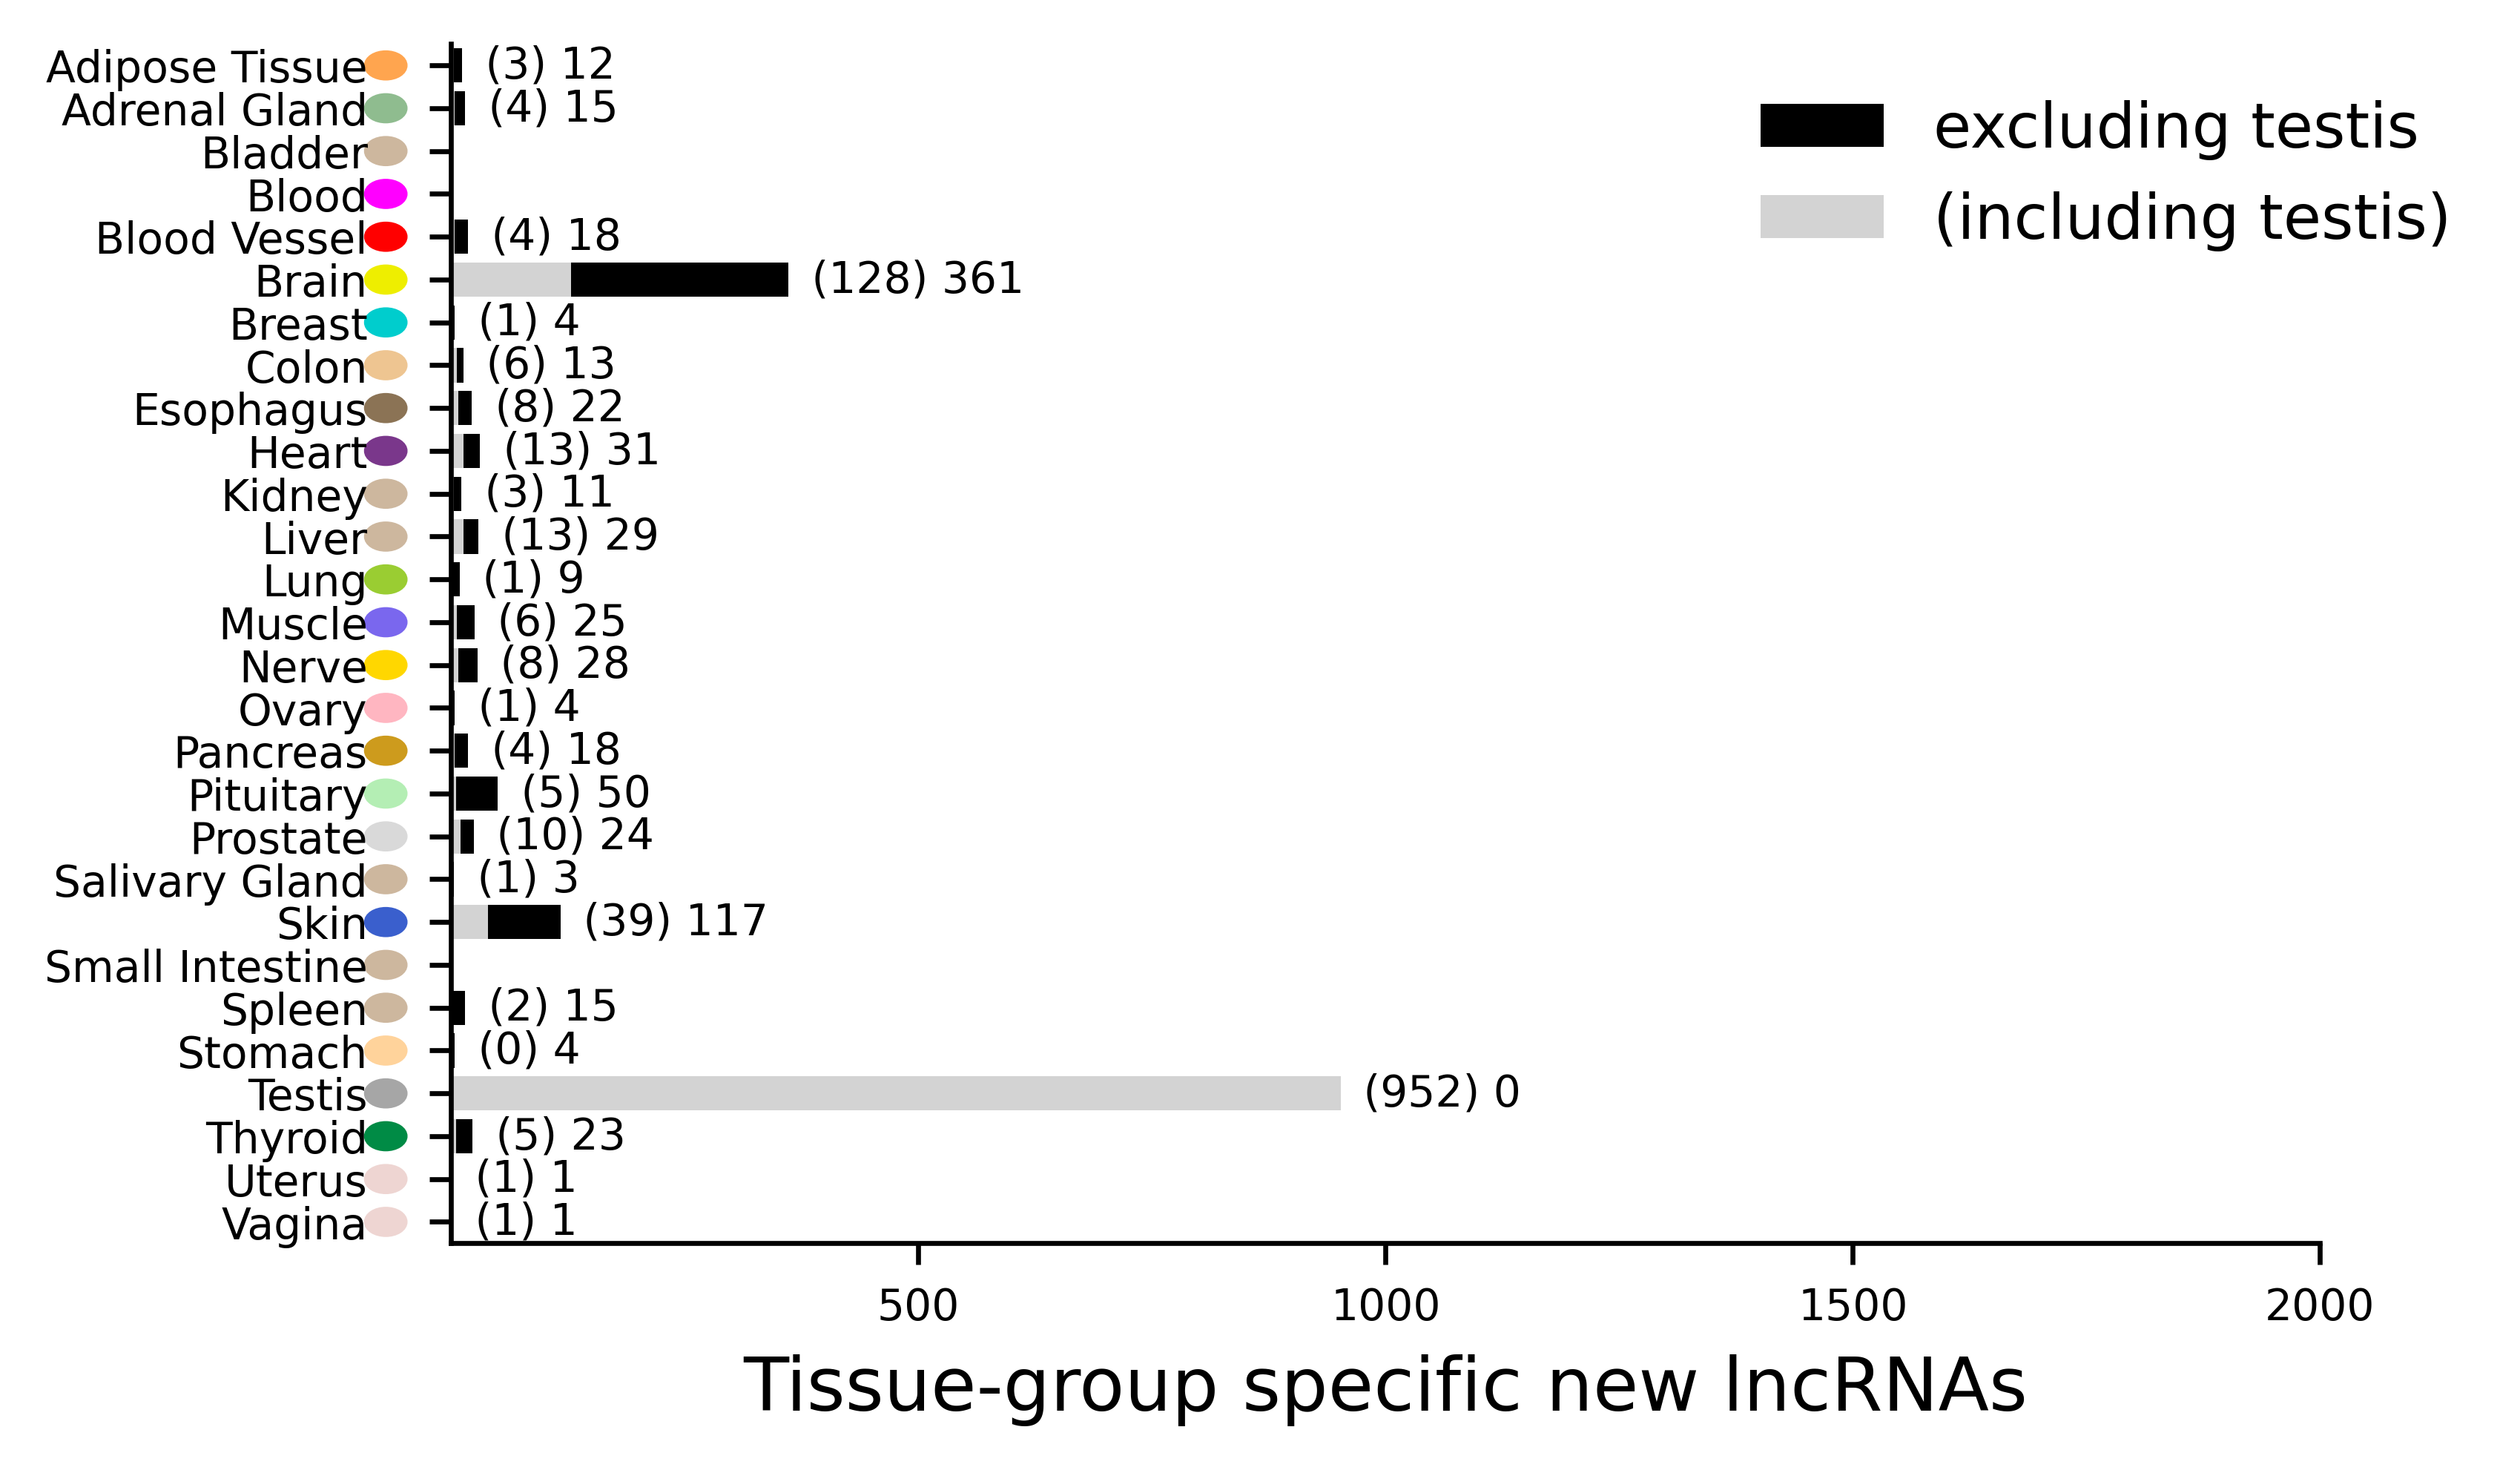

In [64]:
fig, ax = plt.subplots(figsize=(6, 3.5), dpi=600)

sns.barplot(
    data=unique_gene_counts,
    y='tissue_group',
    x='genes',
    hue='variable',
    dodge=False,
    palette=['black', 'lightgrey'],
    ax=ax
)

ax.set_xlabel('Tissue-group specific new lncRNAs', fontsize=12)
ax.set_xticks([500, 1000, 1500, 2000])
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.move_legend(
    ax, "upper right", bbox_to_anchor=(1.1, 1), frameon=False, title='',
    labels=['excluding testis', '(including testis)'], fontsize=10
)

# Add X, Y numbers at the end of the further bar for each tissue
# Only add if at least one value is nonzero
bar_data = unique_gene_counts.pivot(index='tissue_group', columns='variable', values='genes')
for i, tissue in enumerate(bar_data.index):
    x_vals = bar_data.loc[tissue, :]
    if (x_vals > 0).any():
        x1 = x_vals.get('non_testis_unique', 0)
        x2 = x_vals.get('unique', 0)
        ax.text(
             max(x1, x2) + 10, i, f" ({int(x2)}) {int(x1)}",
            va='center', ha='left')

yticks = ax.get_yticks()
yticklabels = [item.get_text() for item in ax.get_yticklabels()]
ax.tick_params(axis='y', pad=10)
y_positions = np.linspace(0, 1-1/len(yticks), len(yticks))[::-1]
for y, tissue in zip(y_positions, yticklabels):
    color = tissue_group_color_map.get(tissue, "#888888")
    circle = patches.Ellipse(
        (-0.035, y + 1/len(yticks)/2), width=.02, height=.02, transform=ax.transAxes,
        color=color, clip_on=False
    )
    ax.add_patch(circle)

plt.subplots_adjust(left=0.2)
plt.show()

In [50]:
# Only expressed in 1 tissue
unique_genes = quantifications[quantifications[tissue_group_columns].sum(axis=1) == 1]

# Only expressed in one tissue (excluding testis)
non_testis_tissue_groups = [t for t in tissue_group_columns if t != 'Testis.group.quantified']
non_testis_unique = quantifications[quantifications[non_testis_tissue_groups].sum(axis=1) == 1].copy()
non_testis_unique['Testis.group.quantified'] = 0

unique_genes = pd.DataFrame(
    unique_genes[unique_genes['gene_type_grouped_highlight'] == 'existing_lncRNA'][tissue_group_columns].sum(axis=0)
).rename(columns={0: 'unique'})
non_testis_unique = pd.DataFrame(
    non_testis_unique[non_testis_unique['gene_type_grouped_highlight'] == 'existing_lncRNA'][tissue_group_columns].sum(axis=0)
).rename(columns={0: 'non_testis_unique'})

unique_gene_counts = pd.merge(non_testis_unique.reset_index(), unique_genes.reset_index(), on='index')
unique_gene_counts['tissue_group'] = unique_gene_counts['index'].str.split('.group').str[0]
unique_gene_counts = unique_gene_counts.melt(
    id_vars='tissue_group', value_name='genes', value_vars=['non_testis_unique', 'unique']
)

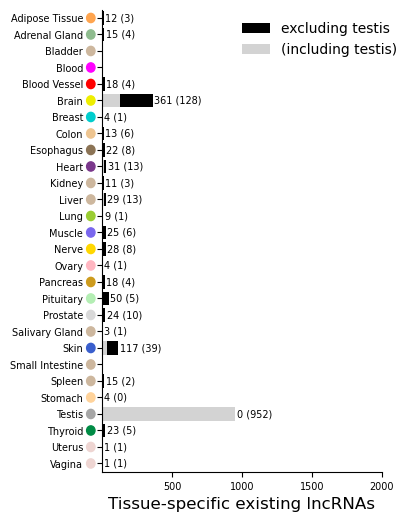

In [51]:
fig, ax = plt.subplots(figsize=(4, 6))

sns.barplot(
    data=unique_gene_counts,
    y='tissue_group',
    x='genes',
    hue='variable',
    dodge=False,
    palette=['black', 'lightgrey'],
    ax=ax
)

ax.set_xlabel('Tissue-specific existing lncRNAs', fontsize=12)
ax.set_xticks([500, 1000, 1500, 2000])
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.move_legend(
    ax, "upper right", bbox_to_anchor=(1.1, 1), frameon=False, title='',
    labels=['excluding testis', '(including testis)'], fontsize=10
)

# Add X, Y numbers at the end of the further bar for each tissue
# Only add if at least one value is nonzero
bar_data = unique_gene_counts.pivot(index='tissue_group', columns='variable', values='genes')
for i, tissue in enumerate(bar_data.index):
    x_vals = bar_data.loc[tissue, :]
    if (x_vals > 0).any():
        x1 = x_vals.get('non_testis_unique', 0)
        x2 = x_vals.get('unique', 0)
        ax.text(
             max(x1, x2) + 10, i, f"{int(x1)} ({int(x2)})",
            va='center', ha='left')

yticks = ax.get_yticks()
yticklabels = [item.get_text() for item in ax.get_yticklabels()]
ax.tick_params(axis='y', pad=10)
y_positions = np.linspace(0, 1-1/len(yticks), len(yticks))[::-1]
for y, tissue in zip(y_positions, yticklabels):
    color = tissue_group_color_map.get(tissue, "#888888")
    circle = patches.Ellipse(
        (-0.04, y + 1/len(yticks)/2), width=.03, height=.02, transform=ax.transAxes,
        color=color, clip_on=False
    )
    ax.add_patch(circle)

plt.subplots_adjust(left=0.2)
plt.show()

In [ ]:
num_tissues

28

In [ ]:
len(tissue_group_columns)

28

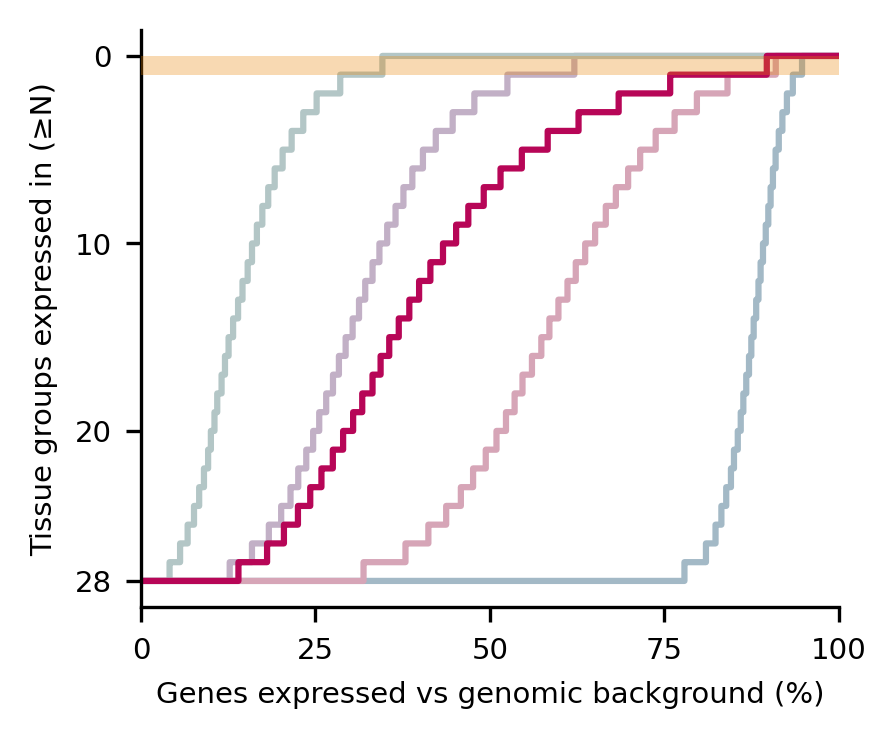

In [ ]:

# Calculate number of tissues each gene is quantified in
quantifications['num_quantified'] = quantifications[tissue_group_columns].sum(axis=1)
num_tissues = quantifications['num_quantified'].max()
quantifications['num_not_quantified'] = num_tissues - quantifications['num_quantified']

# ECDF plot for number of tissues expressed in, by gene type
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=300)

sns.ecdfplot(
    ax=ax,
    data=quantifications,
    y='num_not_quantified',
    hue='gene_type_grouped_highlight',
    hue_order=['new_lncRNA', 'existing_lncRNA', 'protein_coding', 'sRNA', 'pseudogene'],
    palette=gene_type_pal_greyed,
    linewidth=1.5
)

ax.axhspan(num_tissues-1, num_tissues, color='#E98300', alpha=0.3, lw=0, zorder=10)

ax.set_xlabel('Genes expressed vs genomic background (%)')
ax.set_xticks([0, .25, .5, .75, 1])
ax.set_xticklabels([0, 25, 50, 75, 100])
ax.set_ylabel('Tissue groups expressed in (≥N)')
ax.set_yticks([0, 8, 18, 28])
ax.set_yticklabels([0, 10, 20, 28][::-1])
ax.spines[['top', 'right']].set_visible(False)
plt.setp(ax.get_legend(), visible=False)
plt.show()